In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용 - 리눅스 사용할때
import scipy
import scipy.stats as stats

import os
import re
import time
import datetime as dt # 사용시 datetime.dt 로 사용 # 현재 시간 사용
from datetime import datetime # 사용시 함수로 바로 사용 #-> 시간 비교

In [2]:
### 한글 폰트 설치 - 윈도우 사용할 때
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

path = 'c:/Windows/Fonts/malgun.ttf'  # 또는 나눔고딕: 'c:/Windows/Fonts/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

In [3]:
# 경고창 무시
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [4]:
df_heart_stable = pd.read_csv("../../dataset/df_heart_stable_new.csv", index_col = 0)
df_heart_stable.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,0,1,0,0,0,5,2,1,4,1,1,0,1
1,0,20.34,0,0,1,0,0,0,0,0,5,0,1,4,2,0,0,0
2,0,26.58,1,0,0,1,1,0,1,0,5,2,1,1,2,1,0,0
3,0,24.21,0,0,0,0,0,0,0,0,5,0,0,2,2,0,0,1
4,0,23.71,0,0,0,1,0,1,0,1,5,0,1,4,2,0,0,0


## XGBoost

In [5]:
# 훈련용, 시험용 데이터셋 설정
from sklearn.model_selection import train_test_split
labeled_x = df_heart_stable.drop(columns=['HeartDisease'])
labeled_y = df_heart_stable['HeartDisease']

labeled_x_train,labeled_x_test = train_test_split(labeled_x,test_size = 0.3, random_state = 42)
labeled_y_train,labeled_y_test = train_test_split(labeled_y,test_size = 0.3, random_state = 42)

### (1) 랜덤 오버샘플링

In [6]:
# 랜덤 오버샘플링
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
labeled_x_train_resampled, labeled_y_train_resampled = ros.fit_resample(labeled_x_train, labeled_y_train)

In [7]:
labeled_x_train_resampled.shape, labeled_y_train_resampled.shape

((396550, 17), (396550,))

### (2) 임계값 조정 및 튜닝

In [8]:
# grid_search 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0]
}

In [9]:
# 훈련용 데이터 학습
from xgboost import XGBClassifier
# use_label_encoder=Falses는 경고 메시지 방지, logloss는 이진 분류 문제에서 모델의 예측 확률과 실제 레이블 간의 차이를 측정
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  
xgb_model.fit(labeled_x_train_resampled, labeled_y_train_resampled)  # 모델 학습

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [10]:
from sklearn.model_selection import GridSearchCV

# grid_search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=3)
grid_search.fit(labeled_x_train_resampled, labeled_y_train_resampled)

print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


In [11]:
# 최적 모델로 예측
best_model = grid_search.best_estimator_
labeled_y_test_predict_proba = best_model.predict_proba(labeled_x_test)[:, 1]

# 임계값 기본값 예측
labeled_y_test_predict = (labeled_y_test_predict_proba >= 0.5).astype(int)

In [12]:
from sklearn.metrics import f1_score

# 최적의 임계값 찾기 function
def find_best_threshold(y_true, y_proba):
    best_f1 = 0
    best_threshold = 0.5
    thresholds = np.arange(0.0, 1.0, 0.01)
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            
    return best_threshold

# 최적의 임계값
best_threshold = find_best_threshold(labeled_y_test, labeled_y_test_predict_proba)
print(f"최적의 임계값 : {best_threshold}")

최적의 임계값 : 0.6900000000000001


In [13]:
# 시험용 데이터 예측률 확인
labeled_y_test_predict = xgb_model.predict(labeled_x_test)
from sklearn.metrics import classification_report
print("\n분류 보고서:")
print(classification_report(labeled_y_test, labeled_y_test_predict))


분류 보고서:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     84934
           1       0.21      0.75      0.32      7886

    accuracy                           0.73     92820
   macro avg       0.59      0.74      0.58     92820
weighted avg       0.90      0.73      0.79     92820



In [14]:
# 최적의 임계값으로 예측
labeled_y_test_predict_final = (labeled_y_test_predict_proba >= best_threshold).astype(int)
from sklearn.metrics import classification_report
print("\n분류 보고서:")
print(classification_report(labeled_y_test, labeled_y_test_predict_final))


분류 보고서:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     84934
           1       0.29      0.43      0.35      7886

    accuracy                           0.86     92820
   macro avg       0.62      0.67      0.64     92820
weighted avg       0.89      0.86      0.87     92820



## 모델링 결과
- 기존 모델과 비슷한 성능을 보임.

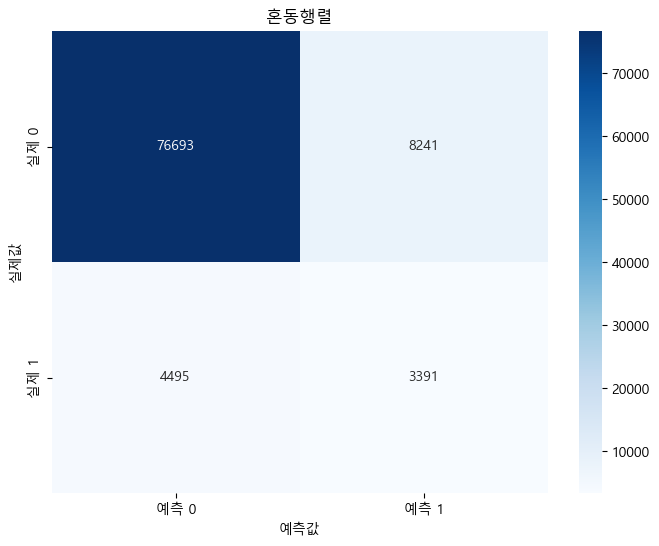

In [18]:
from sklearn.metrics import confusion_matrix
# 혼동행렬 생성
cm = confusion_matrix(labeled_y_test, labeled_y_test_predict_final)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['예측 0', '예측 1'], 
            yticklabels=['실제 0', '실제 1'])
plt.ylabel('실제값')
plt.xlabel('예측값')
plt.title('혼동행렬')
plt.show()

## 피클 내보내기

In [16]:
import pickle

# 객체를 피클 파일로 내보내기
with open('../../pickle/modeling_prediction.pickle', 'wb') as f:
    pickle.dump(xgb_model, f)